# Install dependencies

In [ ]:
%%capture
!pip install dm-env
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-sonnet
!pip install trfl
!pip install dm-reverb
!pip install dm-reverb[tensorflow]
!pip install dm-acme[launchpad]

In [ ]:
!pip install pybullet --quiet

In [ ]:
# Imports
import os
import shutil
import matplotlib
import pybullet_envs

from acme.utils import loggers
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.agents.tf.d4pg import D4PG
from acme.agents.tf.ddpg import DDPG
from acme.agents.tf.dmpo import DistributionalMPO
from acme import wrappers, specs, environment_loop

import numpy as np
import sonnet as snt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from google.colab import drive
from IPython.display import HTML

In [ ]:
# @title Import `pybullet` locomotion environments

from pybullet_envs.gym_locomotion_envs import HopperBulletEnv
from pybullet_envs.gym_locomotion_envs import Walker2DBulletEnv
from pybullet_envs.gym_locomotion_envs import HalfCheetahBulletEnv
from pybullet_envs.gym_locomotion_envs import AntBulletEnv
from pybullet_envs.gym_locomotion_envs import HumanoidBulletEnv

In [ ]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

# Saving and Restoring Checkpoints

In [ ]:
def save_ckpt_to_drive(agent):
  """Saves agent checkpoint directory to Google Drive.

  WARNING: Will replace the entire content of the
  drive directory `/root/drive/MyDrive/acme_ckpt`.

  Args:
    agent: core.Actor
  """
  src = agent._learner._checkpointer._checkpoint_manager.directory
  dst = '/root/drive/MyDrive/acme_ckpt'
  if os.path.exists(dst):
    shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Saved {src} to {dst}')


def restore_ckpt_from_drive(agent):
  """Restores agent checkpoint directory from Google Drive.

  The name of the local checkpoint directory will be different
  than it was when the checkpoint was originally saved.
  This is because `acme` checkpoiner creates a new directory
  upon restart.

  WARNING: Will replace the entire content of the local
  checkpoint directory (if it exists already).

  Args:
    agent: core.Actor
  """
  src = '/root/drive/MyDrive/acme_ckpt'
  dst = agent._learner._checkpointer._checkpoint_manager.directory
  if os.path.exists(dst):
        shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Restored {dst} from {src}')

# Convenience function for creating videos

In [ ]:
def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

# Network factory methods for select continuous control agents

In [ ]:
def make_networks_d4pg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for D4PG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = snt.Sequential([
      networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes,
              activate_final=True),
      ),
      networks.DiscreteValuedHead(vmin=vmin,
                                  vmax=vmax,
                                  num_atoms=num_atoms)
      ])

  return policy_network, critic_network


def make_networks_ddpg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                      ):
  """Networks for DDPG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes + (1,),
              activate_final=False),
              )

  return policy_network, critic_network


def make_networks_dmpo(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for DMPO agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes,
                            activate_final=True),
      networks.MultivariateNormalDiagHead(
          action_size,
          min_scale=1e-6,
          tanh_mean=False,
          init_scale=0.7,
          fixed_scale=False,
          use_tfd_independent=True)
  ])

  # The multiplexer concatenates the (maybe transformed) observations/actions.
  critic_network = networks.CriticMultiplexer(
      action_network=networks.ClipToSpec(action_spec),
      critic_network=networks.LayerNormMLP(layer_sizes=critic_layer_sizes,
                                           activate_final=True),
                                           )
  critic_network = snt.Sequential([
                                   critic_network,
                                   networks.DiscreteValuedHead(vmin=vmin,
                                                               vmax=vmax,
                                                               num_atoms=num_atoms)
                                   ])

  return policy_network, critic_network

# Modifying the environment base class

In [ ]:
class Hopper(HopperBulletEnv):

  def __init__(self, render=False, episode_steps=1000):
    """Modifies `__init__` in `HopperBulletEnv` parent class."""
    self.episode_steps = episode_steps
    super().__init__(render=render)

  def reset(self):
    """Modifies `reset` in `WalkerBaseBulletEnv` base class."""
    self.step_counter = 0
    return super().reset()

  def _isDone(self):
    """Modifies `_isDone` in `WalkerBaseBulletEnv` base class."""
    return (self.step_counter == self.episode_steps
            or super()._isDone())

  def step(self, a):
    """Fully overrides `step` in `WalkerBaseBulletEnv` base class."""

    self.step_counter += 1

    # if multiplayer, action first applied to all robots, 
    # then global step() called, then _step() for all robots
    # with the same actions
    if not self.scene.multiplayer:
      self.robot.apply_action(a)
      self.scene.global_step()

    state = self.robot.calc_state()  # also calculates self.joints_at_limit

    # state[0] is body height above ground, body_rpy[1] is pitch
    self._alive = float(self.robot.alive_bonus(state[0] + self.robot.initial_z,
                                               self.robot.body_rpy[1]))
    done = self._isDone()
    if not np.isfinite(state).all():
      print("~INF~", state)
      done = True

    potential_old = self.potential
    self.potential = self.robot.calc_potential()
    progress = float(self.potential - potential_old)

    feet_collision_cost = 0.0
    for i, f in enumerate(self.robot.feet):
      contact_ids = set((x[2], x[4]) for x in f.contact_list())
      if (self.ground_ids & contact_ids):
        self.robot.feet_contact[i] = 1.0
      else:
        self.robot.feet_contact[i] = 0.0

    # let's assume we have DC motor with controller, and reverse current braking
    electricity_cost = self.electricity_cost * float(
        np.abs(a * self.robot.joint_speeds).mean())
    electricity_cost += self.stall_torque_cost * float(np.square(a).mean())

    joints_at_limit_cost = float(self.joints_at_limit_cost * self.robot.joints_at_limit)

    self.rewards = [
                    self._alive, progress,
                    joints_at_limit_cost, feet_collision_cost
                    ]
    self.HUD(state, a, done)
    self.reward += sum(self.rewards)

    return state, sum(self.rewards), bool(done), {}

# Instantiate the environment

In [ ]:
env = Hopper(render=False)

env = wrappers.GymWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)

action_spec = env.action_spec()  # Specifies action shape and dimensions.
env_spec = specs.make_environment_spec(env)  # Environment specifications.

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
# x and y coordinates of the target location.
env.robot.walk_target_x, env.robot.walk_target_y

(1000.0, 0)

## inspect the environment

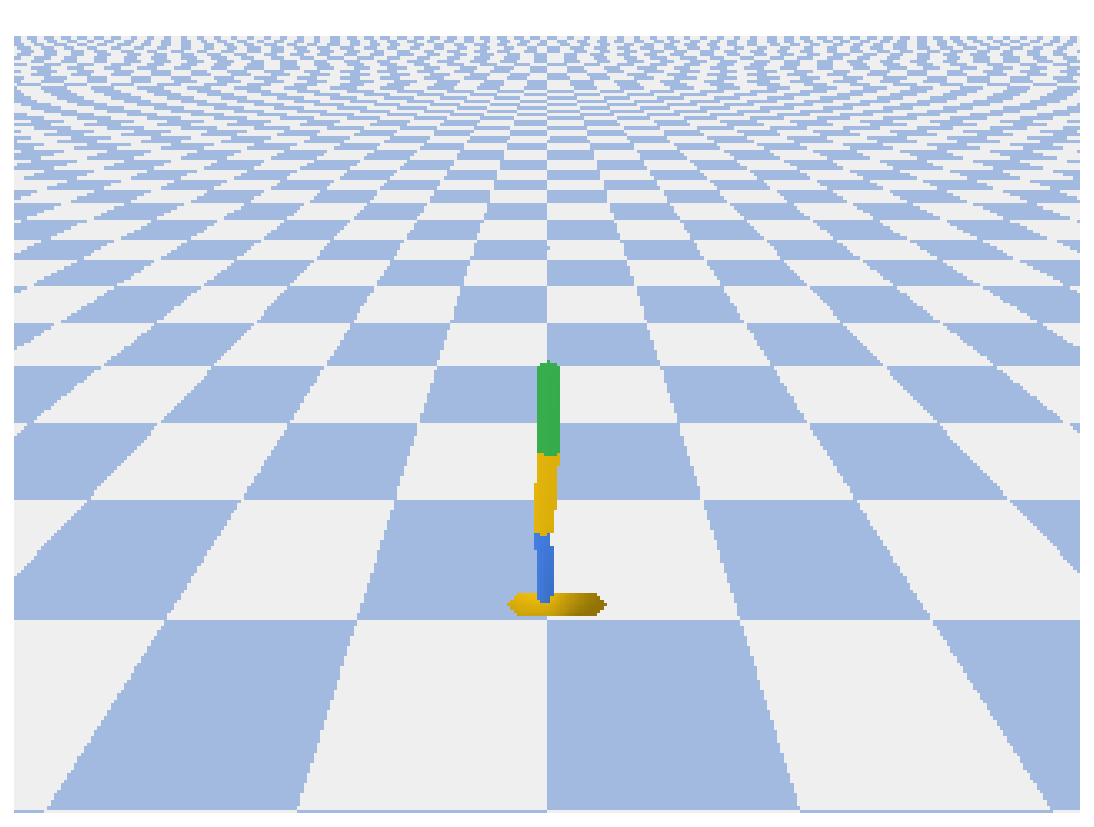

In [ ]:
_ = env.reset()

frame = env.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

## Random Actions

In [ ]:
# Run env for n_steps, apply random actions, and show video.
n_steps = 200

frames = []
timestep = env.reset()
for _ in range(n_steps):
  # Random control of actuators.
  action = np.random.uniform(action_spec.minimum,
                             action_spec.maximum,
                             size=action_spec.shape)
  timestep = env.step(action)
  frames.append(env.environment.render(mode='rgb_array'))

display_video(frames, framerate=20)

error: ignored

# Properties

## Environment Properties

In [ ]:
print('Actions:\n', env_spec.actions)
print('Observations:\n', env_spec.observations)
print('Rewards:\n', env_spec.rewards)


Actions:
 BoundedArray(shape=(3,), dtype=dtype('float32'), name='action', minimum=[-1. -1. -1.], maximum=[1. 1. 1.])
Observations:
 BoundedArray(shape=(15,), dtype=dtype('float32'), name='observation', minimum=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf], maximum=[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf])
Rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


## Robot properties

In [ ]:
# Cartesian coordinates of body parts.
for body_part in env.robot.parts.keys():
  print(f"{body_part:10} {env.robot.parts[body_part].pose().xyz()}")

link0_2    [-0.00438836  0.          0.        ]
torso      [-0.02934519  0.          1.21383844]
link0_3    [-0.00438836  0.         -0.03591239]
link0_4    [-0.00438836  0.         -0.03591239]
link0_6    [-0.02535209  0.          1.01387826]
thigh      [-0.04108653  0.          0.78942913]
link0_8    [-0.05682096  0.          0.56498   ]
leg        [-0.07300543  0.          0.31550442]
link0_10   [-0.0891899   0.          0.06602883]
foot       [-0.02428035  0.          0.06945661]
floor      [0. 0. 0.]


In [ ]:
# Cartesian components of robot speed.
env.robot_body.speed()

array([-0.76173382,  0.        , -0.27702175])

# dm-acme agent

In [ ]:
learner_log_every = 60.  # Learner logging frequency, seconds.
loop_log_every = 60.  # Environment loop logging frequency, seconds.
checkpoint = True  # Checkpoint saved every 10 minutes.

learner_logger = loggers.TerminalLogger(label='Learner',
                                        time_delta=learner_log_every,
                                        print_fn=print)
loop_logger = loggers.TerminalLogger(label='Environment Loop',
                                     time_delta=loop_log_every,
                                     print_fn=print)

# Note: optimizers can be passed only to the D4PG and DMPO agents.
# The optimizer for DDPG is hard-coded in the agent class.
policy_optimizer = snt.optimizers.Adam(1e-2)
critic_optimizer = snt.optimizers.Adam(1e-2)

## D4PG agent

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_d4pg(action_spec)

# Create agent.
agent = D4PG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network=tf2_utils.batch_concat, # Identity Op.
             policy_optimizer=policy_optimizer,
             critic_optimizer=critic_optimizer,
             logger=learner_logger,
             checkpoint=checkpoint)

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_dmpo(action_spec)

# Create agent.
agent_dmpo = DistributionalMPO(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network=tf2_utils.batch_concat, # Identity Op.
             policy_optimizer=policy_optimizer,
             critic_optimizer=critic_optimizer,
             logger=learner_logger,
             checkpoint=checkpoint)

In [ ]:
num_steps = 500_000 # 100_000  # Number of environment loop steps. Adjust as needed!

loop = environment_loop.EnvironmentLoop(env, agent_dmpo, logger=loop_logger)

# Start training!
loop.run(num_episodes=None,
         num_steps=num_steps)

INFO:tensorflow:Assets written to: /root/acme/100eb97c-fdcf-11eb-8bb2-0242ac1c0002/snapshots/policy/assets


INFO:tensorflow:Assets written to: /root/acme/100eb97c-fdcf-11eb-8bb2-0242ac1c0002/snapshots/policy/assets


[Learner] Critic Loss = 2.040 | Dual Alpha Mean = 49.083 | Dual Alpha Stddev = 5.653 | Dual Temperature = 3.078 | Kl Mean Rel = [0.01004046 0.00811424 0.01067394] | Kl Q Rel = 1.155 | Kl Stddev Rel = [3454.268   664.3521  231.4252] | Loss Alpha = 0.142 | Loss Policy = 59.503 | Loss Temperature = 23.655 | Penalty Kl Q Rel = 2.455 | Pi Stddev Cond = 2.179 | Pi Stddev Max = 7.607 | Pi Stddev Min = 3.676 | Policy Loss = [59.50252] | Q Max = 33.951 | Q Min = 29.074 | Steps = 33780 | Walltime = 6230.421
[Environment Loop] Episode Length = 46 | Episode Return = 57.263423919677734 | Episodes = 1 | Steps = 46 | Steps Per Second = 33.880
[Learner] Critic Loss = 2.072 | Dual Alpha Mean = 51.016 | Dual Alpha Stddev = 6.784 | Dual Temperature = 3.238 | Kl Mean Rel = [0.7077699  1.9672412  0.40050578] | Kl Q Rel = 1.491 | Kl Stddev Rel = [11445.181     442.21527   130.6188 ] | Loss Alpha = -0.006 | Loss Policy = 61.773 | Loss Temperature = 22.485 | Penalty Kl Q Rel = 4.922 | Pi Stddev Cond = 3.440 |

INFO:tensorflow:Assets written to: /root/acme/100eb97c-fdcf-11eb-8bb2-0242ac1c0002/snapshots/policy/assets


[Learner] Critic Loss = 1.925 | Dual Alpha Mean = 45.344 | Dual Alpha Stddev = 19.204 | Dual Temperature = 2.772 | Kl Mean Rel = [5.581249   0.06963002 4.5591393 ] | Kl Q Rel = 0.730 | Kl Stddev Rel = [192178.42   111653.73     5922.9253] | Loss Alpha = -3.064 | Loss Policy = 59.176 | Loss Temperature = 23.261 | Penalty Kl Q Rel = 0.946 | Pi Stddev Cond = 5.141 | Pi Stddev Max = 8.589 | Pi Stddev Min = 1.943 | Policy Loss = [59.176487] | Q Max = 33.359 | Q Min = 29.759 | Steps = 46489 | Walltime = 8033.076
[Environment Loop] Episode Length = 51 | Episode Return = 73.05040740966797 | Episodes = 2565 | Steps = 102350 | Steps Per Second = 60.799
[Learner] Critic Loss = 1.940 | Dual Alpha Mean = 44.894 | Dual Alpha Stddev = 19.391 | Dual Temperature = 2.910 | Kl Mean Rel = [0.01245729 0.00410015 0.10505271] | Kl Q Rel = 1.033 | Kl Stddev Rel = [57.171154 16.44807   4.133723] | Loss Alpha = 0.131 | Loss Policy = 58.480 | Loss Temperature = 21.448 | Penalty Kl Q Rel = 1.089 | Pi Stddev Cond 

INFO:tensorflow:Assets written to: /root/acme/100eb97c-fdcf-11eb-8bb2-0242ac1c0002/snapshots/policy/assets


[Learner] Critic Loss = 2.194 | Dual Alpha Mean = 27.121 | Dual Alpha Stddev = 30.537 | Dual Temperature = 3.121 | Kl Mean Rel = [0.09975648 0.12035473 0.97758657] | Kl Q Rel = 1.223 | Kl Stddev Rel = [ 55.921314  62.969673 121.67229 ] | Loss Alpha = 0.064 | Loss Policy = 67.840 | Loss Temperature = 28.487 | Penalty Kl Q Rel = 1.026 | Pi Stddev Cond = 2.059 | Pi Stddev Max = 8.837 | Pi Stddev Min = 4.347 | Policy Loss = [67.84027] | Q Max = 43.589 | Q Min = 38.262 | Steps = 59377 | Walltime = 9834.896
[Environment Loop] Episode Length = 127 | Episode Return = 155.26473999023438 | Episodes = 3943 | Steps = 207088 | Steps Per Second = 55.867
[Learner] Critic Loss = 2.219 | Dual Alpha Mean = 28.850 | Dual Alpha Stddev = 32.673 | Dual Temperature = 3.156 | Kl Mean Rel = [0.03055811 0.01307253 0.38145253] | Kl Q Rel = 0.944 | Kl Stddev Rel = [15.090069  27.542236   2.1144788] | Loss Alpha = 0.082 | Loss Policy = 67.912 | Loss Temperature = 28.197 | Penalty Kl Q Rel = 1.050 | Pi Stddev Cond 

INFO:tensorflow:Assets written to: /root/acme/100eb97c-fdcf-11eb-8bb2-0242ac1c0002/snapshots/policy/assets


[Learner] Critic Loss = 2.474 | Dual Alpha Mean = 19.609 | Dual Alpha Stddev = 49.511 | Dual Temperature = 2.078 | Kl Mean Rel = [0.45878115 0.88365823 0.38695836] | Kl Q Rel = 1.131 | Kl Stddev Rel = [1977.9341    342.15286    39.507732] | Loss Alpha = -0.066 | Loss Policy = 80.116 | Loss Temperature = 41.475 | Penalty Kl Q Rel = 1.029 | Pi Stddev Cond = 2.124 | Pi Stddev Max = 8.330 | Pi Stddev Min = 4.077 | Policy Loss = [80.11627] | Q Max = 58.772 | Q Min = 54.506 | Steps = 72421 | Walltime = 11636.593
[Environment Loop] Episode Length = 886 | Episode Return = 947.2489624023438 | Episodes = 4174 | Steps = 309832 | Steps Per Second = 57.987
[Learner] Critic Loss = 2.462 | Dual Alpha Mean = 20.229 | Dual Alpha Stddev = 51.248 | Dual Temperature = 2.095 | Kl Mean Rel = [0.42953706 5.584982   2.3546739 ] | Kl Q Rel = 1.127 | Kl Stddev Rel = [460.97083 323.40732  81.83823] | Loss Alpha = -0.029 | Loss Policy = 78.101 | Loss Temperature = 39.281 | Penalty Kl Q Rel = 1.032 | Pi Stddev Con

INFO:tensorflow:Assets written to: /root/acme/100eb97c-fdcf-11eb-8bb2-0242ac1c0002/snapshots/policy/assets


[Learner] Critic Loss = 2.503 | Dual Alpha Mean = 32.224 | Dual Alpha Stddev = 76.853 | Dual Temperature = 2.013 | Kl Mean Rel = [0.0342421  0.05662715 0.06077507] | Kl Q Rel = 1.019 | Kl Stddev Rel = [ 1.6439298 16.757807   2.4350126] | Loss Alpha = 0.092 | Loss Policy = 86.358 | Loss Temperature = 47.054 | Penalty Kl Q Rel = 1.030 | Pi Stddev Cond = 2.379 | Pi Stddev Max = 8.860 | Pi Stddev Min = 3.775 | Policy Loss = [86.357544] | Q Max = 65.198 | Q Min = 61.230 | Steps = 85707 | Walltime = 13438.579
[Environment Loop] Episode Length = 1000 | Episode Return = 990.2727661132812 | Episodes = 4305 | Steps = 416955 | Steps Per Second = 56.063
[Learner] Critic Loss = 2.448 | Dual Alpha Mean = 31.411 | Dual Alpha Stddev = 77.025 | Dual Temperature = 2.241 | Kl Mean Rel = [0.15573353 0.21257359 0.22810751] | Kl Q Rel = 0.860 | Kl Stddev Rel = [393.6267    16.616188  89.837555] | Loss Alpha = 0.040 | Loss Policy = 82.509 | Loss Temperature = 43.035 | Penalty Kl Q Rel = 1.008 | Pi Stddev Con

## Examine trained policy

In [ ]:
# Run the environment with the learned policy and display video.
n_steps = 1000

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  timestep = env.step(action)

  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)

In [ ]:
# Run the environment with the learned policy and display video.
n_steps = 2000

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  timestep = env.step(action)

  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)